<a href="https://colab.research.google.com/github/liutianlin0121/sparsity-constrained-ot-demo/blob/main/demo_sparsity_constrained_optimal_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparsity-constrained optimal transport

This is a colab to demonstrate sparsity-constrained optimal transport, as proposed in our work:

> Liu, T., Puigcerver, J., & Blondel, M. (2023). [Sparsity-constrained optimal transport](https://openreview.net/forum?id=yHY9NbQJ5BP). 
Proceedings of the Eleventh International Conference on Learning Representations (ICLR).


In this notebook, we focus on 1D demos (transporting between 1D distributions). For more demos including the applications in 2D, color transfer, and vision mixture-of-experts models, please refer to the [vmoe](https://github.com/google-research/vmoe/tree/main/vmoe/projects/sparsity_constrained_ot) repository.


# Prepare 1D optimal transport data

In [ ]:
!git clone https://github.com/PythonOT/POT.git -q

import sys, os
%cd /content/POT
%pip install -e . -q

import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss


fatal: destination path 'POT' already exists and is not an empty directory.
/content/POT
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for POT (pyproject.toml) ... done


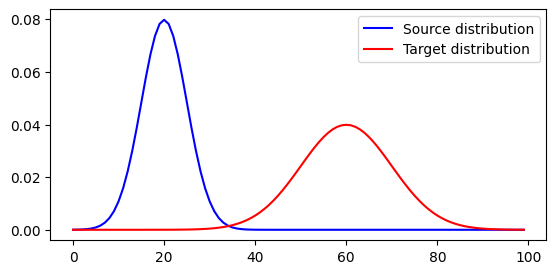

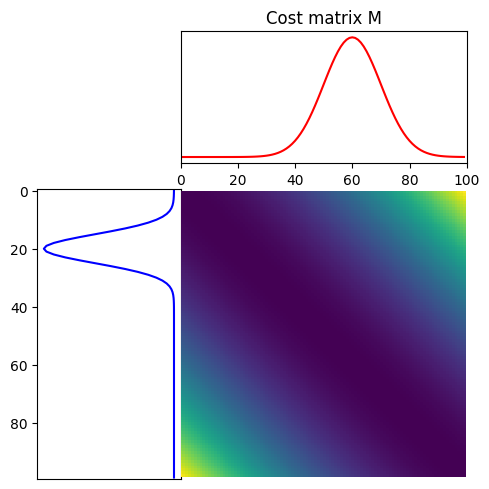

In [ ]:
n = 100  # number of bins
x = np.arange(n, dtype=np.float64) # bin positions

# 1D Gaussian distributions
a = gauss(n, m=20, s=5)  # m= mean, s= std
b = gauss(n, m=60, s=10)

# loss matrix
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
M /= M.max()


# plot the distributions
pl.figure(1, figsize=(6.4, 3))
pl.plot(x, a, 'b', label='Source distribution')
pl.plot(x, b, 'r', label='Target distribution')
pl.legend()

# plot distributions and loss matrix

pl.figure(2, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, M, 'Cost matrix M')


# Baselines: KL and quadratically regularized OT

### KL-regularized OT

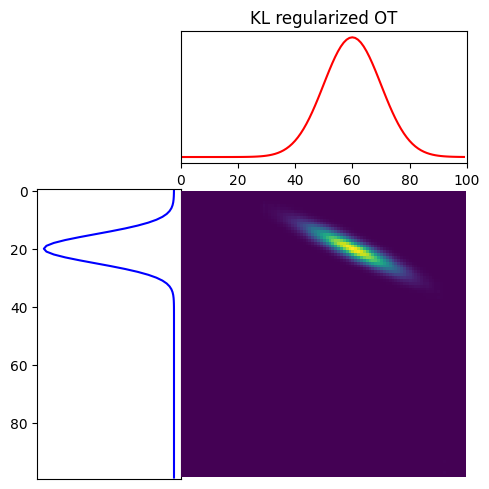

In [ ]:

lambd = 2e-3
Gsm = ot.smooth.smooth_ot_dual(a, b, M, lambd, reg_type='kl')

pl.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, Gsm, 'KL regularized OT')

pl.show()

### Quadratically regularized OT

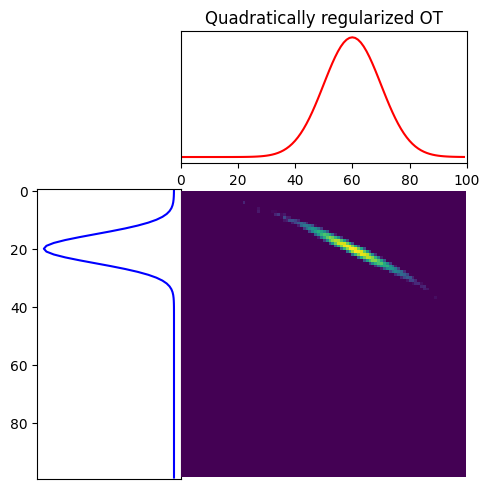

In [ ]:
lambd = 1e-1
Gsm = ot.smooth.smooth_ot_dual(a, b, M, lambd, reg_type='l2')

pl.figure(4, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, Gsm, 'Quadratically regularized OT')

pl.show()

# Sparsity-constrained optimal transport, implemented by POT

The implementation is based on the [Python Optimal Transport (POT)](https://github.com/PythonOT/POT) library. This implementation is compatible with different backends such as NumPy and PyTorch.

In [ ]:
import torch
import jax.numpy as jnp

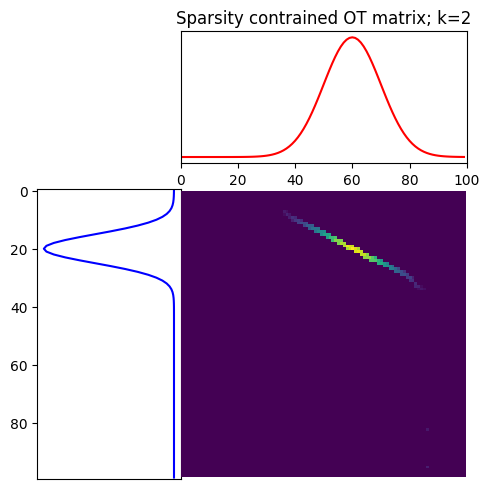

In [ ]:
lambd = 1e-1
max_nz = 2  # two non-zero entries are permitted per column of the OT plan


# use the numpy in sparsity-constrained OT
Gsc_np = ot.smooth.smooth_ot_dual(
    a, b, M, lambd, reg_type='sparsity_constrained', max_nz=max_nz)


# use the pytorch in sparsity-constrained OT
Gsc_torch = ot.smooth.smooth_ot_dual(
    torch.from_numpy(a),
    torch.from_numpy(b),
    torch.from_numpy(M),
    lambd, reg_type='sparsity_constrained', max_nz=max_nz)
  
np.testing.assert_allclose(Gsc_torch.detach().numpy(), Gsc_np)

pl.figure(5, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, Gsc_np, 'Sparsity contrained OT matrix; k=2')

pl.show()

# Sparsity-constrained optimal transport, implemented with JAXopt

The implementation of sparsity-constrained OT is based on JAX. It uses the [JAXopt](https://jaxopt.github.io/stable/index.html) library.



In [ ]:
!pip install git+https://github.com/google/jaxopt -q


  Preparing metadata (setup.py) ... done


In [ ]:
"""Projection with k-sparse constraints."""
from typing import Callable, Any
import jax
import jax.numpy as jnp
import jaxopt
from jaxopt._src.projection import projection_sparse_simplex, projection_transport, _make_semi_dual #, _regularized_transport_semi_dual



def _max_l2_top_k(x, k, marginal_b=1.0, gamma=1.0):
  scale = gamma * marginal_b
  p = jaxopt.projection.projection_sparse_simplex(x / scale, k)
  p = jax.lax.stop_gradient(p)
  z = jnp.dot(p, x) - 0.5 * scale * jnp.dot(p, p)
  return z

_max_l2_top_k_grad = jax.grad(_max_l2_top_k)


def _regularized_transport_semi_dual(cost_matrix,
                           marginals_a,
                           marginals_b,
                           make_solver,
                           max_vmap,
                           max_grad_vmap,
                           gamma=1.0):

  r"""Regularized transport in the semi-dual formulation.

  Args:
    cost_matrix: The cost matrix of size (m, n).
    marginals_a: The marginals of size (m,)
    marginals_b: The marginals of size (n,)
    make_solver: A function that makes the optimization algorithm
    max_vmap:  A function that computes the regularized max on columns of
      its matrix-valued input
    max_grad_vmap:  A function that computes gradient of regularized max
      on columns of its matrix-valued input
    gamma: A parameter that controls the strength of regularization.

  Returns:
    The optimized plan. See the text under Eqn. (10) of
      https://arxiv.org/abs/1710.06276
  """
  size_a, size_b = cost_matrix.shape

  if len(marginals_a.shape) >= 2:
    raise ValueError("marginals_a should be a vector.")

  if len(marginals_b.shape) >= 2:
    raise ValueError("marginals_b should be a vector.")

  if size_a != marginals_a.shape[0] or size_b != marginals_b.shape[0]:
    raise ValueError("cost_matrix and marginals must have matching shapes.")

  if make_solver is None:
    make_solver = lambda fun: jaxopt.LBFGS(fun=fun, tol=1e-3, maxiter=500,
                                    linesearch="zoom")

  semi_dual = _make_semi_dual(max_vmap, gamma=gamma)
  solver = make_solver(semi_dual)
  alpha_init = jnp.zeros(size_a)

  # Optimal dual potentials.
  alpha = solver.run(alpha_init,
                     cost_matrix=cost_matrix,
                     marginals_a=marginals_a,
                     marginals_b=marginals_b).params

  # Optimal primal transportation plan.
  X = alpha[:, jnp.newaxis] - cost_matrix
  P = max_grad_vmap(X, marginals_b, gamma).T * marginals_b

  return P, alpha


def k_sparse_projection_transport(sim_matrix: jnp.ndarray,
                                  marginals_a: jnp.ndarray,
                                  marginals_b: jnp.ndarray,
                                  k: int,
                                  row_k_sparse: bool = False,
                                  make_solver: Callable[..., Any] = None,
                                  gamma=1.0,
                                  return_alpha=False):
  r"""Projection onto the transportation polytope with k-sparse constraints.

  Args:
    sim_matrix: similarity matrix, shape=(size_a, size_b).
    marginals_a: marginals a, shape=(size_a,).
    marginals_b: marginals b, shape=(size_b,).
    k: number of nonzeros that each row (if row_k_sparse is True) or
    column (if row_k_sparse is False) can have at most.
    row_k_sparse: if True, each row of transportation plan has at most k
      nonzeros; else, each column of transportation plan has at most k
      nonzeros.
    make_solver: a function of the form make_solver(fun),
      for creating an iterative solver to minimize fun.
    gamma: a parameter that controls the strength of squared l2 regularization.
  Returns:
    plan: transportation matrix, shape=(size_a, size_b).
  References:
    Liu, T., Puigcerver, J., & Blondel, M. (2023).
    Sparsity-constrained optimal transport. 
    Proceedings of the Eleventh International Conference on Learning 
      Representations (ICLR).
  """

  def maxop(x, marginal_b, gamma):
    return _max_l2_top_k(x, k=k, marginal_b=marginal_b, gamma=gamma)

  maxop_vmap = jax.vmap(maxop, in_axes=(1, 0, None))
  max_grad_vmap = jax.vmap(jax.grad(maxop), in_axes=(1, 0, None))

  if row_k_sparse:
    # enforce sparsity constraint rowwise:
    marginals_a, marginals_b = marginals_b, marginals_a
    sim_matrix = sim_matrix.T

  plan, alpha = _regularized_transport_semi_dual(
      cost_matrix=-sim_matrix,  # pylint: disable=protected-access
      marginals_a=marginals_a,
      marginals_b=marginals_b,
      make_solver=make_solver,
      max_vmap=maxop_vmap,
      max_grad_vmap=max_grad_vmap,
      gamma=gamma)
  if row_k_sparse:
    plan = plan.T

  if return_alpha:
    return plan, alpha
  else:
    return plan

In [ ]:
sparsity_constrained_plan = k_sparse_projection_transport(-M, a, b, k=2)

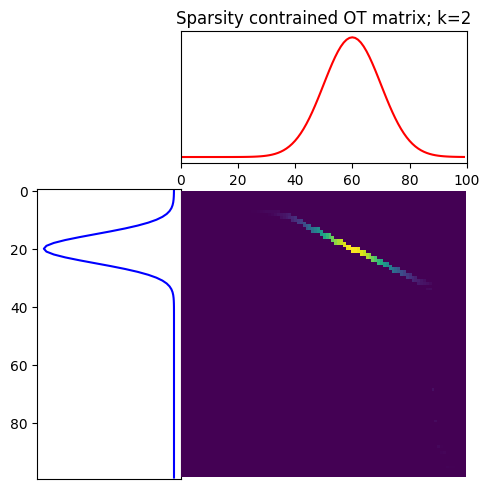

In [ ]:
pl.figure(6, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, sparsity_constrained_plan, 'Sparsity contrained OT matrix; k=2')

pl.show()

# More applications

See the [vmoe](https://github.com/google-research/vmoe/tree/main/vmoe/projects/sparsity_constrained_ot) repo for more demos of sparsity-constrained OT, including its applications in 2D samples, color transfer, and vision mixture-of-experts.


If you find these implementations helpful, consider citing our paper:


> Liu, T., Puigcerver, J., & Blondel, M. (2023). [Sparsity-constrained optimal transport](https://openreview.net/forum?id=yHY9NbQJ5BP). 
Proceedings of the Eleventh International Conference on Learning Representations (ICLR).